# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

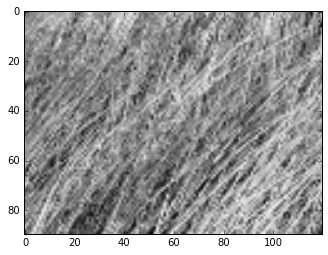

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)
sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[-1.11651213 -1.01944808 -0.23999337 ..., -0.12147499 -1.15733176
  -1.52699203]
 [-0.28189271 -0.92650059 -0.3284865  ...,  0.78656064 -0.78029405
   1.12758945]
 [ 0.39623557 -0.8335531  -0.01876054 ...,  1.19013202  0.17680168
   3.23846147]
 ..., 
 [-2.1597864   0.14239556 -0.85944528 ...,  0.3493583  -0.72228825
   1.03164073]
 [ 1.49167355 -0.36881564 -1.25766437 ...,  0.08031071  0.98888291
   0.10413635]
 [-0.54271128  1.86192413 -0.90369185 ...,  1.02197728  0.5538394
  -0.27965856]]


Define combined kernel using GPy library:

In [5]:
import GPy

kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
#kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=10000)

Extract latent X from the model:

In [7]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -0.73909516  |               |        
  [0 1]      |         0.77056645  |               |        
  [0 2]      |        -0.98034634  |               |        
  [0 3]      |        -1.02327629  |               |        
  [0 4]      |        -0.06331815  |               |        
  [0 5]      |        -1.65880261  |               |        
  [0 6]      |         1.31427110  |               |        
  [0 7]      |         0.78024948  |               |        
  [0 8]      |        -0.02818581  |               |        
  [0 9]      |        -0.21137101  |               |        
  [ 0 10]    |        -0.32704932  |               |        
  [ 0 11]    |         1.10560093  |               |        
  [ 0 12]    |        -0.37922713  |               |        
  [ 0 13]    |         0.91453727  |               |        
  [ 0 14]    |        -0.79209570  |               |        
  [ 0 15]    |         1

In [28]:
# Save data to tmp file
np.save('test_X', X)

Plot first 5 values to visualize:

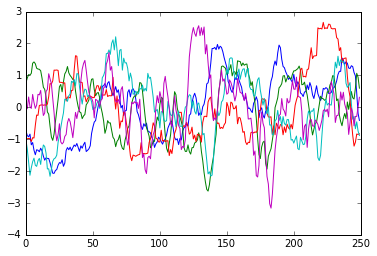

In [11]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [12]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.9699655   0.45788718  0.29649023 ...,  0.03160388  0.05153132
   0.06444564]
 [ 0.45788718  1.00300759  0.49576039 ...,  0.02089854  0.04738761
   0.06531162]
 [ 0.29649023  0.49576039  1.03956029 ...,  0.03147918  0.05247829
   0.07027064]
 ..., 
 [ 0.03160388  0.02089854  0.03147918 ...,  0.95581226  0.238164
   0.07289802]
 [ 0.05153132  0.04738761  0.05247829 ...,  0.238164    0.94629014
   0.25629887]
 [ 0.06444564  0.06531162  0.07027064 ...,  0.07289802  0.25629887
   0.93282621]]


Function to predict new artificial frame using mean prediction method:

In [13]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [35]:
N_synt = N  #for evaluation - the same number as in the input
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[ -5.01974989e-01   3.77172882e-01  -5.84623924e-01 ...,   9.58992035e-04
   -8.12161739e-01  -6.00649452e-02]
 [ -4.86821514e-01   2.82457878e-01  -5.11218449e-01 ...,   9.99004723e-03
   -5.11114094e-01  -4.84294416e-02]
 [ -4.56210087e-01   2.19292796e-01  -4.70400877e-01 ...,  -1.95494868e-04
   -3.32271877e-01   2.43603738e-02]
 ..., 
 [ -1.73498310e-02   2.33062860e-01  -5.04538759e-01 ...,  -7.60952058e-02
   -3.42119819e-01   1.79078724e-01]
 [ -4.35510858e-02   2.29662289e-01  -5.07556317e-01 ...,  -7.48465706e-02
   -3.42945807e-01   1.72807221e-01]
 [ -7.91141952e-02   2.28355708e-01  -5.07559936e-01 ...,  -8.88620731e-02
   -3.69020099e-01   1.75858099e-01]]


Plot of new X:

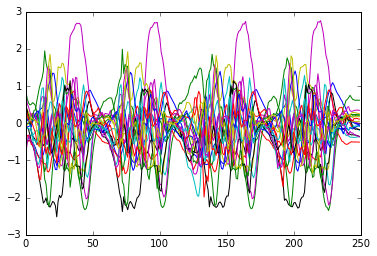

In [36]:
mp.plot(X_synt)

In [37]:
# Save data to tmp file
np.save('test_X_synt', X_synt)

Now perform syntesis of the dinamic texture based on new X by using multivariate Gaussian:

In [47]:
Y_synt = np.zeros((N_synt,D))

kernel2 = kernel #GPy.kern.RBF(Q,ARD=True) #try original kernel
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)


    
k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt)
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[ 1.67653088  1.58664735  0.13268155 ...,  1.44006821 -0.20757469
   0.28257373]
 [ 2.37135215  1.1890538   0.94678492 ...,  0.85730716 -0.96044196
   0.87450702]
 [ 2.68799102  0.55831049  1.80866109 ...,  0.9837865  -0.12805507
   1.1499309 ]
 ..., 
 [ 2.39302666 -0.05129526  0.21733693 ...,  2.06418044 -1.88107607
   2.23781863]
 [ 2.71347623  0.24117236  0.70785114 ...,  1.78978104 -1.98844537
   1.97506273]
 [ 2.76419117  0.41903174  0.98754865 ...,  1.80930306 -2.061196
   1.83962749]]


In [48]:
# Save data to tmp file
np.save('test_Y_synt', Y_synt)

Display first frame:

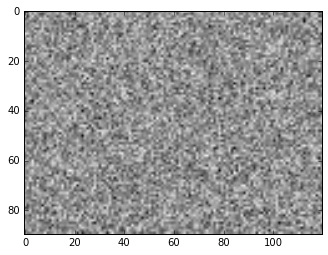

In [49]:
show_frame(Y_synt[1,:])

Finally, save video (currently correctly works with pictures only):

In [51]:
for i in range(N_synt):
    print(i)
    frame = Y_synt[i,:].reshape((h,w)).astype(int)
    
    ind = 'data/frame' + str(i) + '.jpg'
    mp.imsave(ind,frame,cmap='Greys_r')
    #img = mp.imread('data/test.png')
    
    #out.write(img)
    #print(img)

#cap.release()
#out.release()
cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Done!


In [41]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-21.672359262 20.9984032886


In [ ]:
frame = Y_synt[90,:].reshape((h,w)).astype(int)
max = frame.max()
min = frame.min()
frame = (255/(max - min))*(frame - min)
print(frame,frame.min(),frame.max())
mp.imshow(frame,cmap='Greys_r')

In [ ]:
mp.imshow(Y_synt[90,:].reshape((h,w)).astype(int),cmap='Greys_r')

In [ ]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)

In [ ]:
Y_synt_denorm = sample_std * Y_synt + sample_mean

In [44]:
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [43]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)

In [45]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    #colorFrame = np.zeros((w,h,3), np.uint8)
    #colorFrame = cv2.COLOR_GRAY2RGB(frame)
    #new_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    #colorFrame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[101 101 101]
  [135 135 135]
  [118 118 118]
  ..., 
  [124 124 124]
  [135 135 135]
  [142 142 142]]

 [[119 119 119]
  [113 113 113]
  [147 147 147]
  ..., 
  [112 112 112]
  [130 130 130]
  [112 112 112]]

 [[128 128 128]
  [105 105 105]
  [120 120 120]
  ..., 
  [127 127 127]
  [140 140 140]
  [ 99  99  99]]

 ..., 
 [[134 134 134]
  [ 85  85  85]
  [178 178 178]
  ..., 
  [147 147 147]
  [143 143 143]
  [117 117 117]]

 [[132 132 132]
  [140 140 140]
  [116 116 116]
  ..., 
  [129 129 129]
  [151 151 151]
  [126 126 126]]

 [[129 129 129]
  [124 124 124]
  [122 122 122]
  ..., 
  [124 124 124]
  [141 141 141]
  [124 124 124]]]
1
[[[ 93  93  93]
  [145 145 145]
  [115 115 115]
  ..., 
  [119 119 119]
  [136 136 136]
  [154 154 154]]

 [[105 105 105]
  [107 107 107]
  [156 156 156]
  ..., 
  [102 102 102]
  [126 126 126]
  [107 107 107]]

 [[126 126 126]
  [ 94  94  94]
  [121 121 121]
  ..., 
  [129 129 129]
  [142 142 142]
  [ 84  84  84]]

 ..., 
 [[136 136 136]
  [ 64  64  

In [ ]:
img = mp.imshow(Y_synt_denorm[0,:].reshape((h,w)).astype(int))

In [ ]:
print(img)

In [ ]:
img2=mp.imsave('p.png',Y_synt_denorm[0,:].reshape((h,w)).astype(int))

In [ ]:
help(mp.imsave)

In [52]:
#denormalizing every frame
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output2.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min) 
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    #colorFrame = np.zeros((w,h,3), np.uint8)
    #colorFrame = cv2.COLOR_GRAY2RGB(frame)
    #new_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    #colorFrame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[153 153 153]
  [153 153 153]
  [127 127 127]
  ..., 
  [127 127 127]
  [127 127 127]
  [153 153 153]]

 [[204 204 204]
  [102 102 102]
  [153 153 153]
  ..., 
  [153 153 153]
  [102 102 102]
  [102 102 102]]

 [[178 178 178]
  [ 25  25  25]
  [127 127 127]
  ..., 
  [178 178 178]
  [ 51  51  51]
  [ 76  76  76]]

 ..., 
 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [153 153 153]
  [ 76  76  76]]

 [[127 127 127]
  [127 127 127]
  [178 178 178]
  ..., 
  [ 76  76  76]
  [178 178 178]
  [127 127 127]]

 [[127 127 127]
  [102 102 102]
  [102 102 102]
  ..., 
  [153 153 153]
  [127 127 127]
  [127 127 127]]]
1
[[[159 159 159]
  [143 143 143]
  [127 127 127]
  ..., 
  [111 111 111]
  [127 127 127]
  [159 159 159]]

 [[175 175 175]
  [ 95  95  95]
  [175 175 175]
  ..., 
  [143 143 143]
  [111 111 111]
  [ 95  95  95]]

 [[159 159 159]
  [ 47  47  47]
  [127 127 127]
  ..., 
  [175 175 175]
  [ 63  63  63]
  [ 79  79  79]]

 ..., 
 [[143 143 143]
  [127 127 1